In [1]:
# Imports
import os
import subprocess
import collections
import math
import numpy as np
from scipy.io import wavfile
import pandas as pd

In [2]:
import IPython
from pylab import plot, show, figure, imshow
%matplotlib inline
import matplotlib.pyplot as plt

# Visualization library
import seaborn as sns
sns.set(style="white", color_codes=True)
sns.set_context(rc={"font.family":'sans',"font.size":24,"axes.titlesize":24,"axes.labelsize":24})

import warnings 
warnings.filterwarnings("ignore")

In [3]:
# Global variables
AUDIO_FILE = 'resources/Sassuolo 1-4 AC Milan Trionfo del Milan sul Sassuolo con doppietta di Suso Serie A (online-audio-converter.com).wav'
EXT = '.wav'
EXT_SIZE = len(EXT)
SAMPLE_RATE = 44100
# Change in case OS is not MacOS
PRAAT = '/usr/bin/praat'
RUN_OPTIONS = '--run'
PRAAT_SCRIPT = 'audio_info_extraction.praat'
PRAAT_SCRIPT_SILENCES = 'silences_info_extraction.praat' 
# Parameters praat
WINDOW_SIZE = 0.02
HOP_SIZE = 0.01
PITCH_MIN = 75
PITCH_MAX = 300
MAX_PERIOD_FACTOR = 1.3
MAX_AMPLITUDE_FACTOR = 1.6
SILENCE_THRESHOLD = 0.03
VOICING_THRESHOLD = 0.45
SILENCE_THRESHOLD_DB = -25
MINIMUM_SILENT_INTERVAL_DURATION = 0.1
MINIMUM_SOUNDING_INTERVAL_DURATION = 0.05
TIME_DECIMALS = 6

N_SIGMA = 2

In [4]:
# File names data frames
PARAMS = AUDIO_FILE[:-EXT_SIZE] + '_pitch_param_file.csv'
PITCH_TIER = AUDIO_FILE[:-EXT_SIZE] + '_pitch_tier.csv'
INTENSITY_TIER = AUDIO_FILE[:-EXT_SIZE] + '_intensity_tier.csv'
VOICE_REPORT = AUDIO_FILE[:-EXT_SIZE] + '_voice_report.csv'

SILENCES_TABLE = AUDIO_FILE[:-EXT_SIZE] + '_silences.csv'

CLEAN_PITCH_TIER = AUDIO_FILE[:-EXT_SIZE] + '_clean_pitch_tier.csv'
CLEAN_INTENSITY_TIER = AUDIO_FILE[:-EXT_SIZE] + '_clean_intensity_tier.csv'
CLEAN_VOICE_REPORT = AUDIO_FILE[:-EXT_SIZE] + '_clean_voice_report.csv'

In [5]:
# Data types for data frames
DTYPE_PARAMS = {"dx_pitch": float,
               "dx_intensity": float,
               "window_size_vr": float,
               "window_shift_vr": float}
DTYPE_PITCH_TIER = {'Time': float,
                    'F0': float}
DTYPE_INTENSITY_TIER_OLD = {"Time (s)": float,
                            "Intensity (dB)": float}
DTYPE_INTENSITY_TIER = {"Time": float,
                        "Intensity": float}
DTYPE_VOICE_REPORT_OLD = {"start_time": float,
                          "end_time": float,
                          "harmonicity": str,
                          "jitter": str,
                          "shimmer": str}
DTYPE_VOICE_REPORT = {"start_time": float,
                      "end_time": float,
                      "harmonicity": float,
                      "jitter": float,
                      "shimmer": float}

DTYPE_SILENCES = {"tmin": float,
                  "text": str,
                  "tmax": float}

In [6]:
# Load audio file
sample_rate, audio = wavfile.read(AUDIO_FILE)
audio = audio / np.amax(audio)

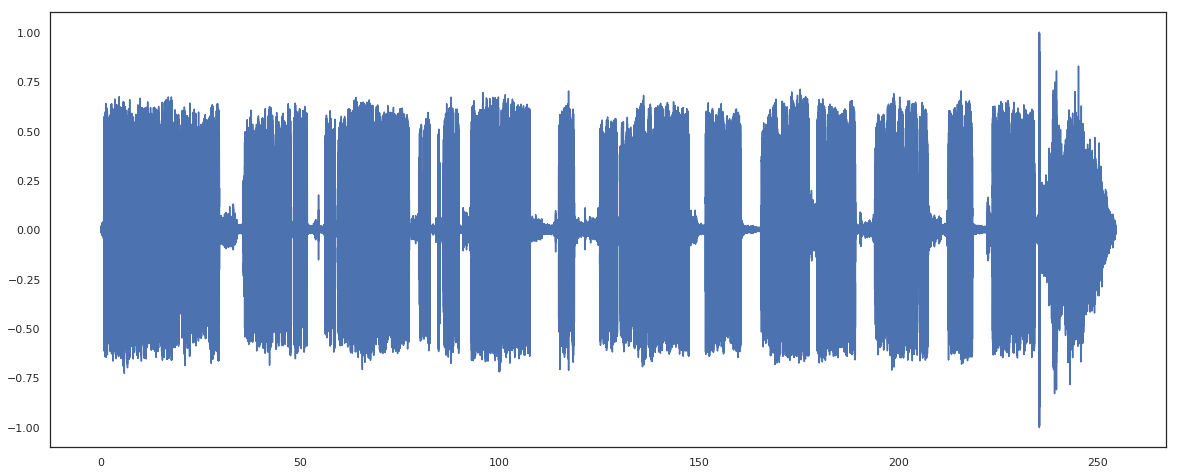

In [7]:
# Display audio waveform
time = np.linspace(0, len(audio)/float(SAMPLE_RATE), len(audio))
plt.figure(figsize=(20,8))
plt.plot(time, audio)

In [8]:
# Extract praat features
subprocess.call([PRAAT,
                 RUN_OPTIONS,
                 PRAAT_SCRIPT,
                 AUDIO_FILE,
                 PARAMS,
                 PITCH_TIER,
                 INTENSITY_TIER,
                 VOICE_REPORT,
                 str(WINDOW_SIZE),
                 str(HOP_SIZE),
                 str(PITCH_MIN),
                 str(PITCH_MAX),
                 str(MAX_PERIOD_FACTOR),
                 str(MAX_AMPLITUDE_FACTOR),
                 str(SILENCE_THRESHOLD),
                 str(VOICING_THRESHOLD)])

0

In [9]:
# Load pitch tier and related parameters
params_df = pd.read_csv(PARAMS, dtype=DTYPE_PARAMS)
pitch_tier_df = pd.read_csv(PITCH_TIER, dtype=DTYPE_PITCH_TIER)
ds_pitch = params_df["dx_pitch"].values[0]

In [10]:
# Clean pitch tier by removing values outside the specified n sigma std interval
pitch_values = pitch_tier_df["F0"].values
mean = np.mean(pitch_values, axis=0)
std = np.std(pitch_values, axis=0)
query = "F0 >= " + str(mean) + " - " + str(N_SIGMA * std) + " and F0 <= " + str(mean) + " + " + str(N_SIGMA * std)
clean_pitch_tier_df = pitch_tier_df.query(query)

clean_pitch_tier_df.to_csv(CLEAN_PITCH_TIER, index=False)

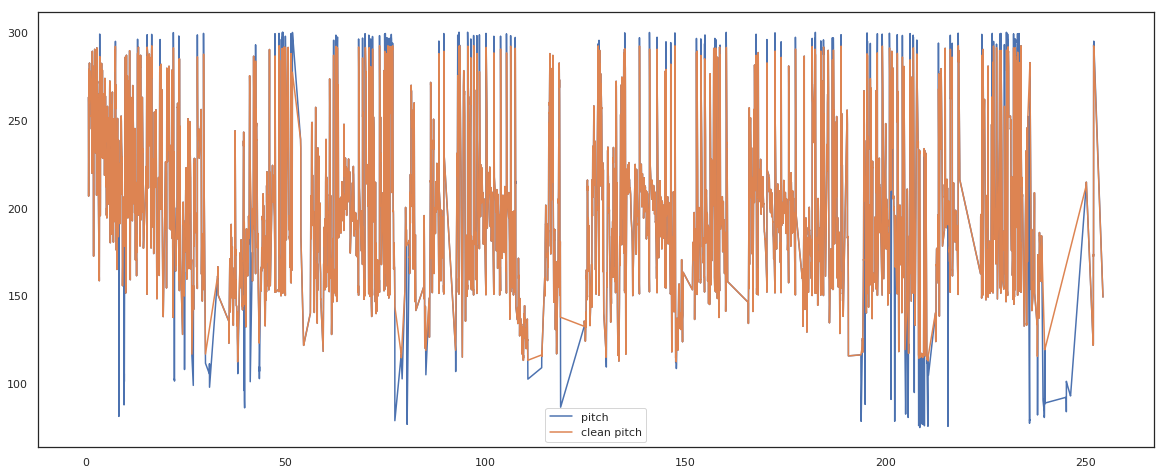

In [11]:
# Plot original pitch and clean pitch tier
plt.figure(figsize=(20,8))
plt.plot(pitch_tier_df['Time'].values, pitch_tier_df['F0'].values, label='pitch')
plt.plot(clean_pitch_tier_df['Time'].values, clean_pitch_tier_df['F0'].values, label='clean pitch')
plt.legend(loc='best')

In [12]:
pitch_tier_df['F0'].describe()

count    12091.000000
mean       202.301381
std         45.007043
min         74.954265
25%        170.085923
50%        196.907943
75%        233.181810
max        299.936528
Name: F0, dtype: float64

In [13]:
clean_pitch_tier_df['F0'].describe()

count    11610.000000
mean       201.995687
std         41.017995
min        112.351176
25%        170.971935
50%        196.593058
75%        229.912171
max        292.296403
Name: F0, dtype: float64

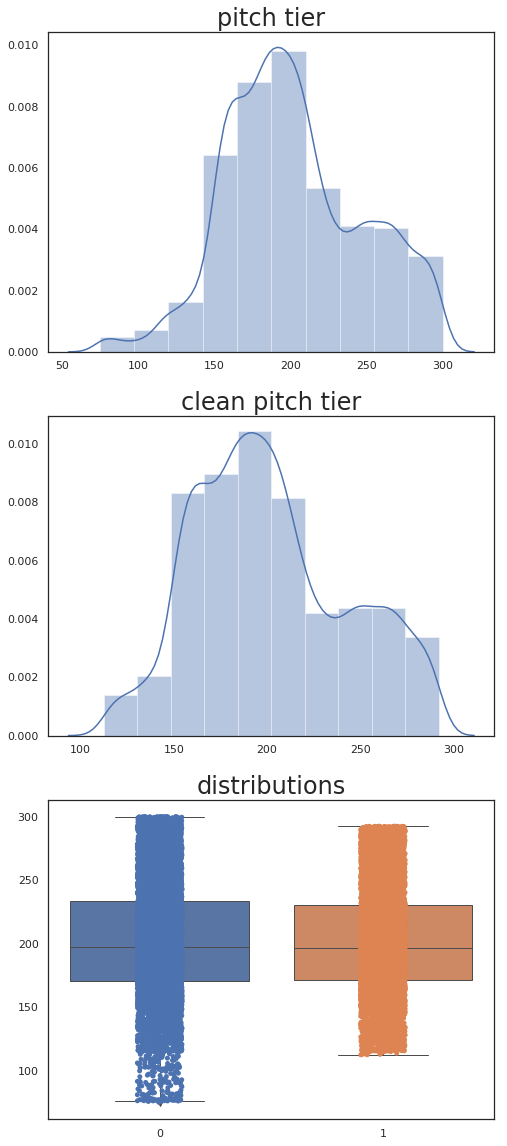

In [14]:
# Plot original pitch and clean pitch tier distributions
plt.figure(figsize=(8,20))

plt.subplot(3, 1, 1, title='pitch tier')
sns.distplot(pitch_tier_df['F0'].values, bins=10)

plt.subplot(3, 1, 2, title='clean pitch tier')
sns.distplot(clean_pitch_tier_df['F0'].values, bins=10)

plt.subplot(3, 1, 3, title='distributions')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})
ax = sns.boxplot(data=list([pitch_tier_df['F0'].values, clean_pitch_tier_df['F0'].values]))
ax = sns.stripplot(data=list([pitch_tier_df['F0'].values, clean_pitch_tier_df['F0'].values]), jitter=True, edgecolor="gray")

In [15]:
# Load intensity tier and related parameters
intensity_tier_df = pd.read_csv(INTENSITY_TIER, dtype=DTYPE_INTENSITY_TIER_OLD)
dx_intensity = params_df["dx_intensity"].values[0]

# Rename columns
intensity_tier_df = intensity_tier_df.rename(columns={"Time (s)": "Time", "Intensity (dB)": "Intensity"})
intensity_tier_df.to_csv(INTENSITY_TIER, index=False)

In [16]:
# Clean pitch tier by removing values outside the specified n sigma std interval
intensity_values = intensity_tier_df["Intensity"].values
mean = np.mean(intensity_values, axis=0)
std = np.std(intensity_values, axis=0)
query = "Intensity >= " + str(mean) + " - " + str(N_SIGMA * std) + " and Intensity <= " + str(mean) + " + " + str(N_SIGMA * std)
clean_intensity_tier_df = intensity_tier_df.query(query)

clean_intensity_tier_df.to_csv(CLEAN_INTENSITY_TIER, index=False)

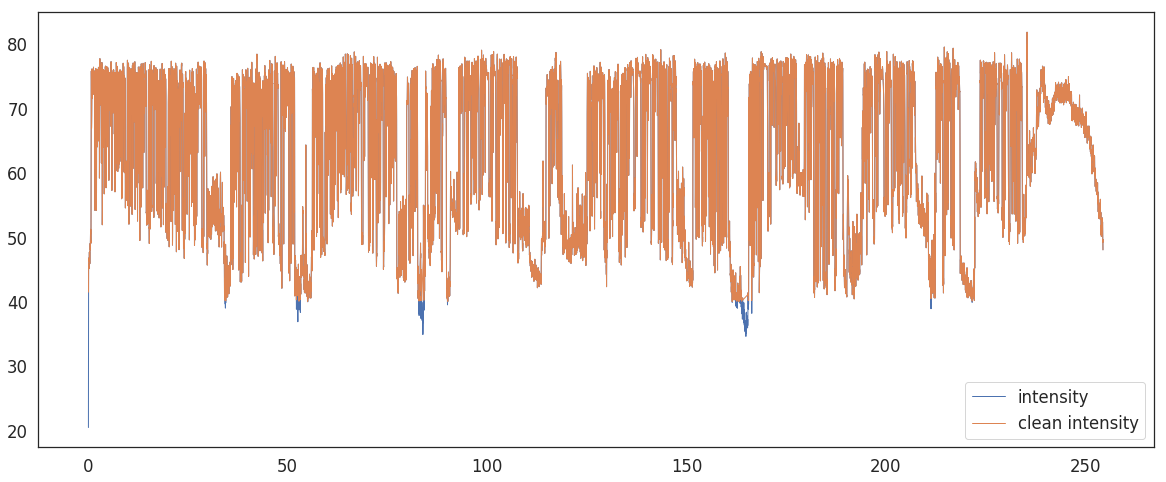

In [17]:
# Plot original intensity and clean intensity tier
plt.figure(figsize=(20,8))
plt.plot(intensity_tier_df['Time'].values, intensity_tier_df['Intensity'].values, label='intensity')
plt.plot(clean_intensity_tier_df['Time'].values, clean_intensity_tier_df['Intensity'].values, label='clean intensity')
plt.legend(loc='best')

In [18]:
intensity_tier_df['Intensity'].describe()

count    23851.000000
mean        63.639298
std         11.843493
min         20.409818
25%         52.692933
50%         68.495899
75%         74.318842
max         81.723044
Name: Intensity, dtype: float64

In [19]:
clean_intensity_tier_df['Intensity'].describe()

count    23547.000000
mean        63.970552
std         11.551208
min         39.952991
25%         53.105132
50%         68.734326
75%         74.358474
max         81.723044
Name: Intensity, dtype: float64

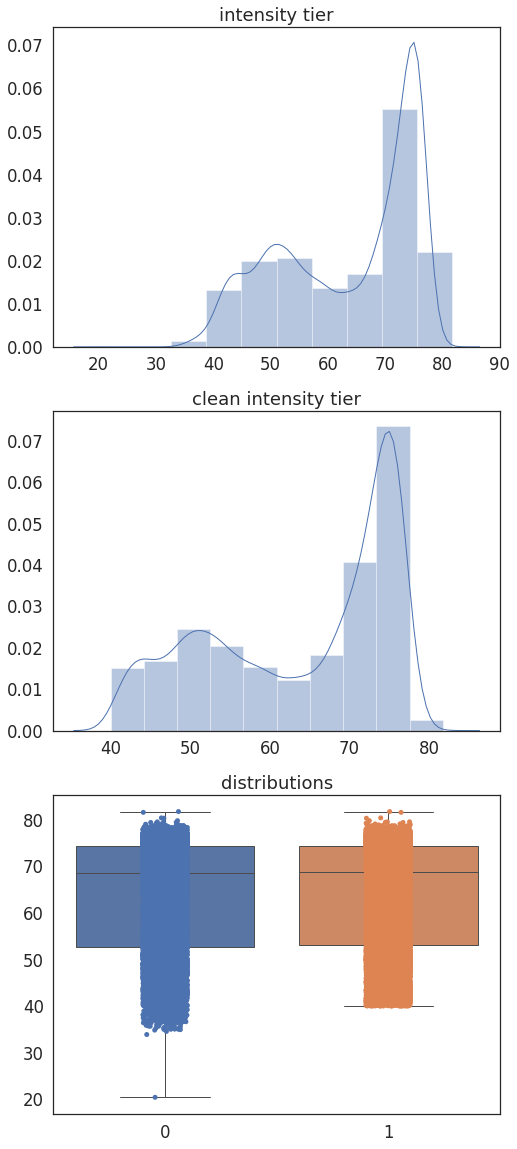

In [20]:
# Plot original intensity and clean intensity tier distributions
plt.figure(figsize=(8,20))

plt.subplot(3, 1, 1, title='intensity tier')
sns.distplot(intensity_tier_df['Intensity'].values, bins=10)

plt.subplot(3, 1, 2, title='clean intensity tier')
sns.distplot(clean_intensity_tier_df['Intensity'].values, bins=10)

plt.subplot(3, 1, 3, title='distributions')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})
ax = sns.boxplot(data=list([intensity_tier_df['Intensity'].values, clean_intensity_tier_df['Intensity'].values]))
ax = sns.stripplot(data=list([intensity_tier_df['Intensity'].values, clean_intensity_tier_df['Intensity'].values]), jitter=True, edgecolor="gray")

In [21]:
# Load voice report and related parameters
voice_report_df = pd.read_csv(VOICE_REPORT, dtype=DTYPE_VOICE_REPORT_OLD)
window_size = params_df["window_size_vr"].values[0]
hop_size = params_df["window_shift_vr"].values[0]

# Re-manage types and re-load
voice_report_df = voice_report_df.replace("--undefined--", np.nan)
voice_report_df.to_csv(CLEAN_VOICE_REPORT, index=False)

clean_voice_report_df = pd.read_csv(CLEAN_VOICE_REPORT, dtype=DTYPE_VOICE_REPORT)

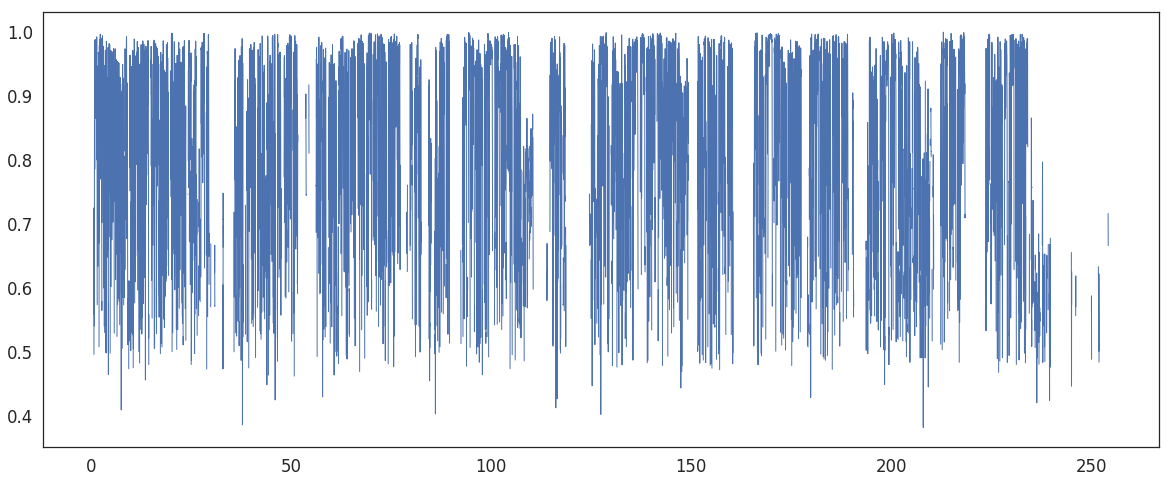

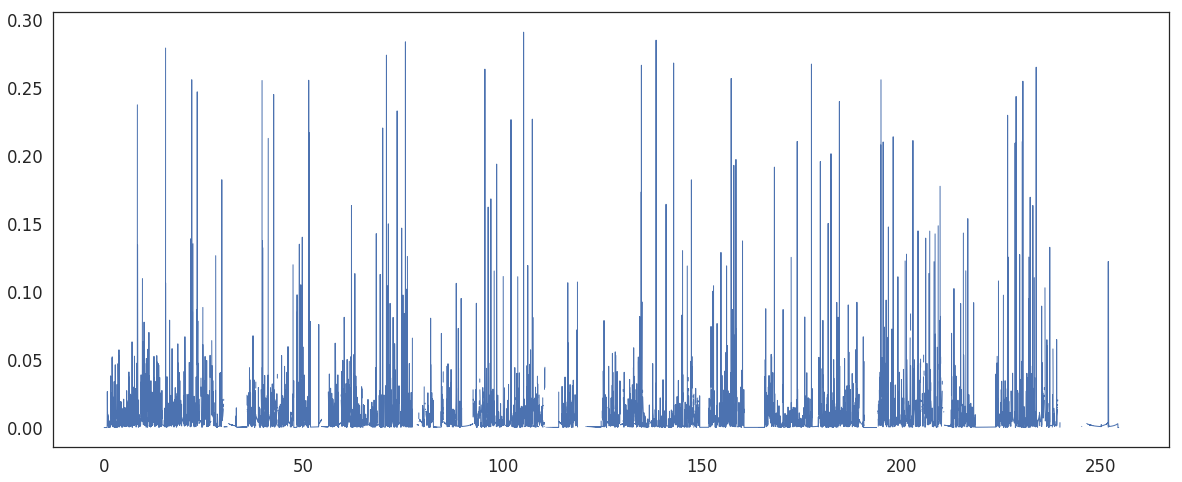

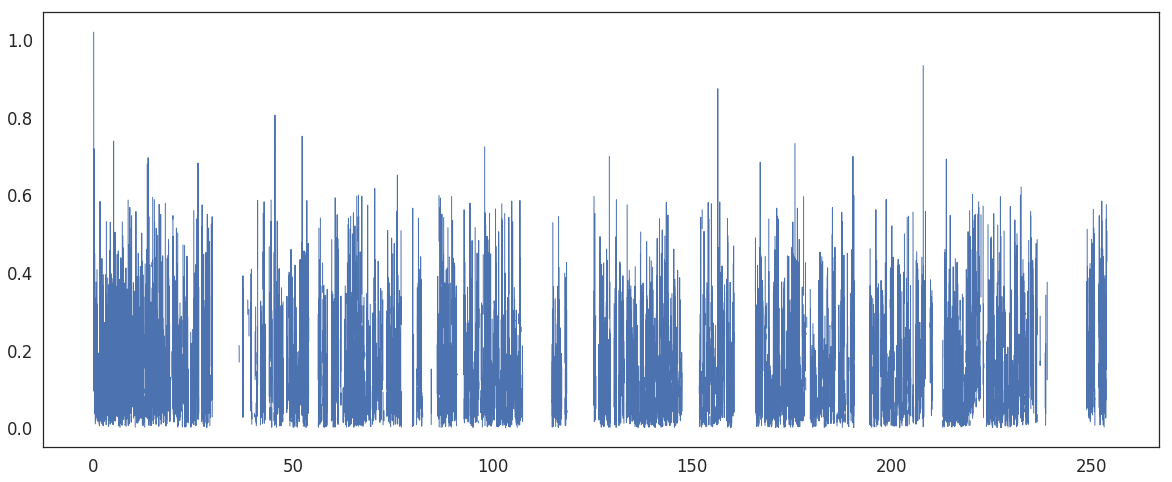

In [22]:
plt.figure(figsize=(20,8))
plt.plot(clean_voice_report_df['start_time'].values + hop_size, clean_voice_report_df['harmonicity'].values, label='harmonicity')

plt.figure(figsize=(20,8))
plt.plot(clean_voice_report_df['start_time'].values + hop_size, clean_voice_report_df['jitter'].values, label='jitter')

plt.figure(figsize=(20,8))
plt.plot(clean_voice_report_df['start_time'].values + hop_size, clean_voice_report_df['shimmer'].values, label='shimmer')

In [23]:
clean_voice_report_df[['harmonicity', 'jitter', 'shimmer']].describe()

,harmonicity,jitter,shimmer
count,13243.000000,22056.000000,11896.000000
mean,0.829086,0.008283,0.147845
std,0.139204,0.016351,0.126332
min,0.381132,0.000000,0.000020
25%,0.731703,0.001230,0.049170
50%,0.868476,0.003810,0.110555
75%,0.949219,0.009340,0.216853
max,0.997732,0.290810,1.017700


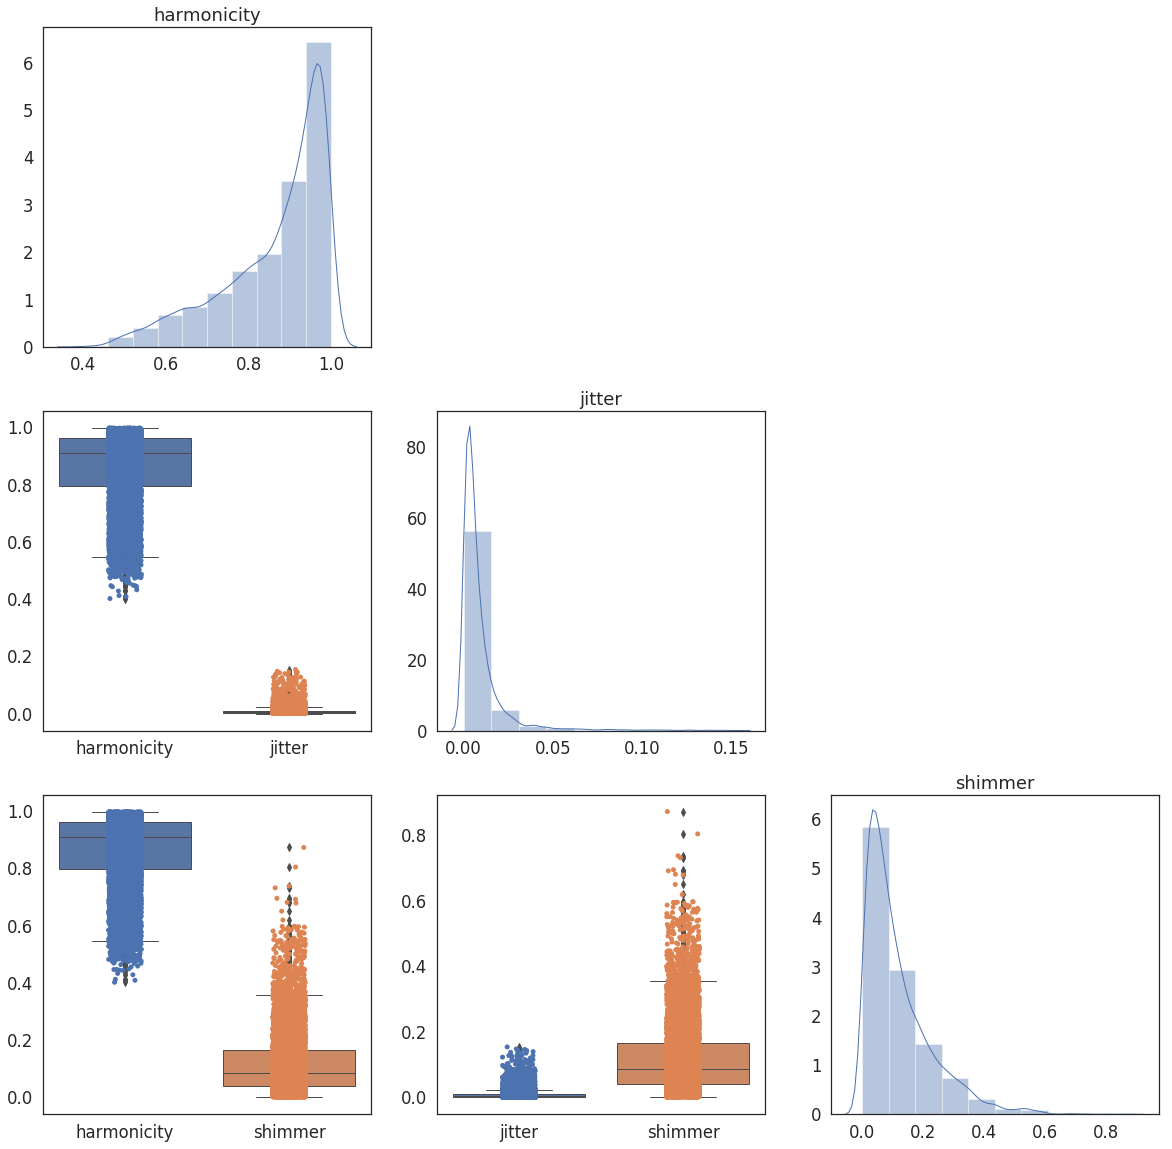

In [24]:
clean_voice_report_df_delete_rows = clean_voice_report_df.dropna(axis=0)

plt.figure(figsize=(20,20))

plt.subplot(3, 3, 1, title='harmonicity')
sns.distplot(clean_voice_report_df_delete_rows['harmonicity'].values, bins=10)

plt.subplot(3, 3, 4)
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})
ax = sns.boxplot(data=clean_voice_report_df_delete_rows[['harmonicity', 'jitter']])
ax = sns.stripplot(data=clean_voice_report_df_delete_rows[['harmonicity', 'jitter']], jitter=True, edgecolor="gray")

plt.subplot(3, 3, 5, title='jitter')
sns.distplot(clean_voice_report_df_delete_rows['jitter'].values, bins=10)

plt.subplot(3, 3, 7)
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})
ax = sns.boxplot(data=clean_voice_report_df_delete_rows[['harmonicity', 'shimmer']])
ax = sns.stripplot(data=clean_voice_report_df_delete_rows[['harmonicity', 'shimmer']], jitter=True, edgecolor="gray")

plt.subplot(3, 3, 8)
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})
ax = sns.boxplot(data=clean_voice_report_df_delete_rows[['jitter', 'shimmer']])
ax = sns.stripplot(data=clean_voice_report_df_delete_rows[['jitter', 'shimmer']], jitter=True, edgecolor="gray")


plt.subplot(3, 3, 9, title='shimmer')
sns.distplot(clean_voice_report_df_delete_rows['shimmer'].values, bins=10)

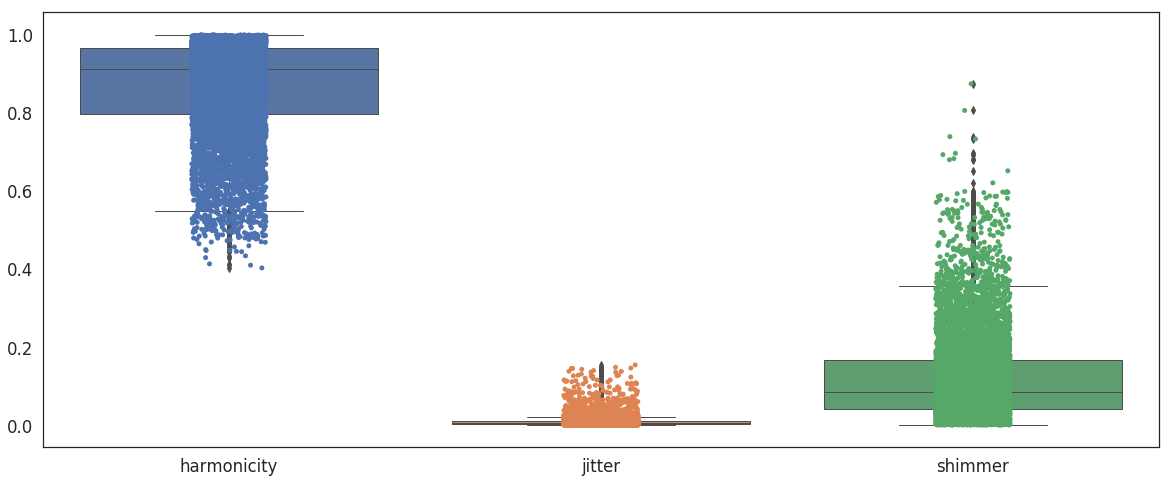

In [25]:
plt.figure(figsize=(20,8))

plt.plot()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})
ax = sns.boxplot(data=clean_voice_report_df_delete_rows[['harmonicity', 'jitter', 'shimmer']])
ax = sns.stripplot(data=clean_voice_report_df_delete_rows[['harmonicity', 'jitter', 'shimmer']], jitter=True, edgecolor="gray")

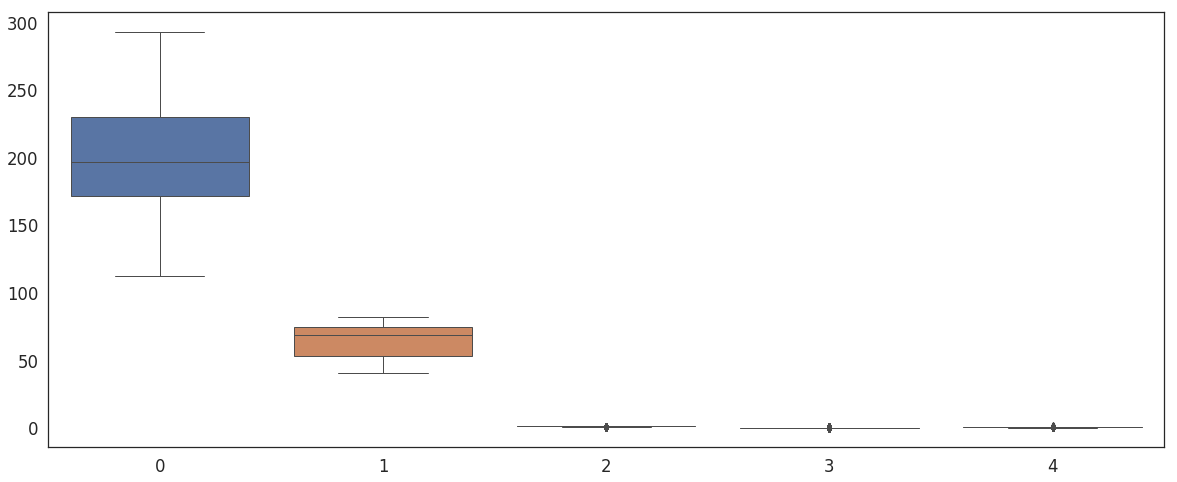

In [26]:
plt.figure(figsize=(20,8))

plt.plot()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})
ax = sns.boxplot(data=[clean_pitch_tier_df['F0'], clean_intensity_tier_df['Intensity'], clean_voice_report_df_delete_rows['harmonicity'], clean_voice_report_df_delete_rows['jitter'], clean_voice_report_df_delete_rows['shimmer']])

In [27]:
# Normalization by hand
pitch_df_normalized_values = clean_pitch_tier_df['F0'].values - np.mean(clean_pitch_tier_df['F0'].values)
pitch_df_normalized_values = pitch_df_normalized_values / np.max(np.abs(pitch_df_normalized_values))
pitch_df_normalized = pd.DataFrame(data=pitch_df_normalized_values, columns=['F0'])

intensity_df_normalized_values = clean_intensity_tier_df['Intensity'].values - np.mean(clean_intensity_tier_df['Intensity'].values)
intensity_df_normalized_values = intensity_df_normalized_values / np.max(np.abs(intensity_df_normalized_values))
intensity_df_normalized = pd.DataFrame(data=intensity_df_normalized_values, columns=['Intensity'])

harmonicity_df_normalized_values = clean_voice_report_df_delete_rows['harmonicity'].values - np.mean(clean_voice_report_df_delete_rows['harmonicity'].values)
harmonicity_df_normalized_values = harmonicity_df_normalized_values / np.max(np.abs(harmonicity_df_normalized_values))
harmonicity_df_normalized = pd.DataFrame(data=harmonicity_df_normalized_values, columns=['harmonicity'])

jitter_df_normalized_values = clean_voice_report_df_delete_rows['jitter'].values - np.mean(clean_voice_report_df_delete_rows['jitter'].values)
jitter_df_normalized_values = jitter_df_normalized_values  / np.max(np.abs(jitter_df_normalized_values))
jitter_df_normalized = pd.DataFrame(data=jitter_df_normalized_values, columns=['jitter'])

shimmer_df_normalized_values = clean_voice_report_df_delete_rows['shimmer'].values - np.mean(clean_voice_report_df_delete_rows['shimmer'].values)
shimmer_df_normalized_values = shimmer_df_normalized_values / np.max(np.abs(shimmer_df_normalized_values))
shimmer_df_normalized = pd.DataFrame(data=shimmer_df_normalized_values, columns=['shimmer'])

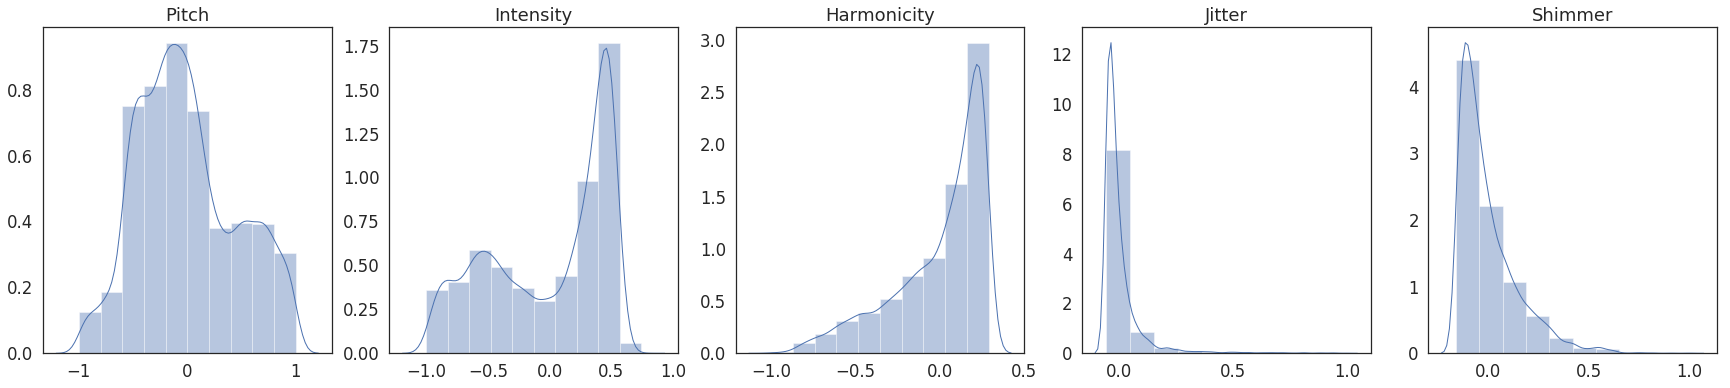

In [28]:
plt.figure(figsize=(30,6))

plt.subplot(1, 5, 1, title='Pitch')
sns.distplot(pitch_df_normalized['F0'].values, bins=10)

plt.subplot(1, 5, 2, title='Intensity')
sns.distplot(intensity_df_normalized['Intensity'].values, bins=10)

plt.subplot(1, 5, 3, title='Harmonicity')
sns.distplot(harmonicity_df_normalized['harmonicity'].values, bins=10)

plt.subplot(1, 5, 4, title='Jitter')
sns.distplot(jitter_df_normalized['jitter'].values, bins=10)

plt.subplot(1, 5, 5, title='Shimmer')
sns.distplot(shimmer_df_normalized['shimmer'].values, bins=10)

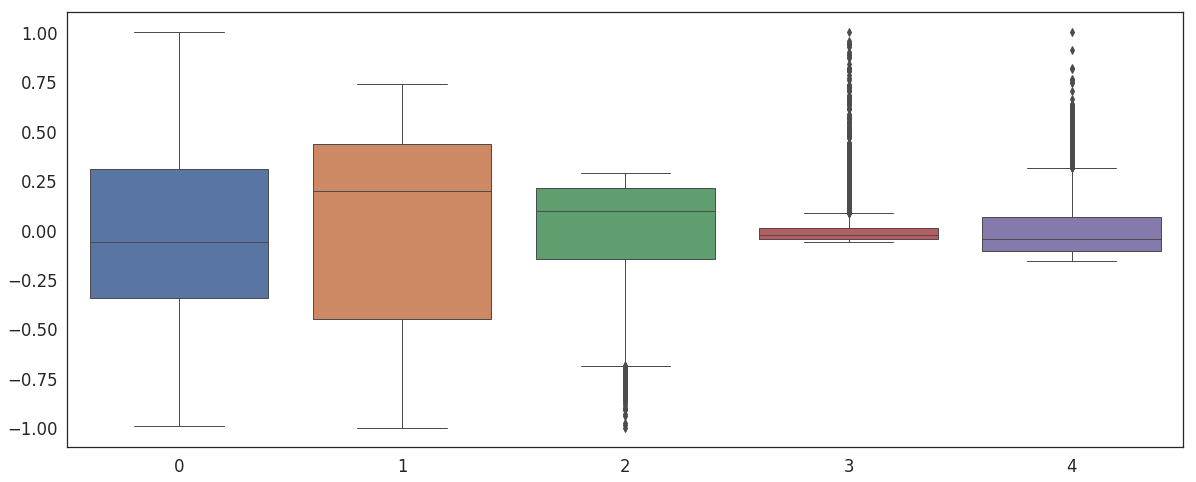

In [29]:
plt.figure(figsize=(20,8))

plt.plot()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})
ax = sns.boxplot(data=[pitch_df_normalized, intensity_df_normalized, harmonicity_df_normalized, jitter_df_normalized, shimmer_df_normalized])

In [30]:
# Post process voice report due to the high number of outliers and skewness
harmonicity_df_values = clean_voice_report_df_delete_rows['harmonicity'].values
mean = np.mean(harmonicity_df_values, axis=0)
std = np.std(harmonicity_df_values, axis=0)
query = "harmonicity >= " + str(mean) + " - " + str(N_SIGMA * std) + " and harmonicity <= " + str(mean) + " + " + str(N_SIGMA * std)
clean_harmonicity_df = clean_voice_report_df_delete_rows.query(query)
harmonicity_df_normalized_values = clean_harmonicity_df['harmonicity'].values - np.mean(clean_harmonicity_df['harmonicity'].values)
harmonicity_df_normalized_values = harmonicity_df_normalized_values  / np.max(np.abs(harmonicity_df_normalized_values))
#harmonicity_df_normalized_values = np.log1p(harmonicity_df_normalized_values)
harmonicity_df_normalized = pd.DataFrame(data=harmonicity_df_normalized_values, columns=['harmonicity'])

jitter_df_values = clean_voice_report_df_delete_rows['jitter'].values
mean = np.mean(jitter_df_values, axis=0)
std = np.std(jitter_df_values, axis=0)
query = "jitter >= " + str(mean) + " - " + str(std) + " and jitter <= " + str(mean) + " + " + str(std)
clean_jitter_df = clean_voice_report_df_delete_rows.query(query)
jitter_df_normalized_values = clean_jitter_df['jitter'].values - np.mean(clean_jitter_df['jitter'].values)
jitter_df_normalized_values = jitter_df_normalized_values  / np.max(np.abs(jitter_df_normalized_values))
jitter_df_normalized_values = np.log1p(jitter_df_normalized_values)
jitter_df_normalized = pd.DataFrame(data=jitter_df_normalized_values, columns=['jitter'])

shimmer_df_values = clean_voice_report_df_delete_rows['shimmer'].values
mean = np.mean(shimmer_df_values, axis=0)
std = np.std(shimmer_df_values, axis=0)
query = "shimmer >= " + str(mean) + " - " + str(N_SIGMA * std) + " and shimmer <= " + str(mean) + " + " + str(N_SIGMA * std)
clean_shimmer_df = clean_voice_report_df_delete_rows.query(query)
shimmer_df_normalized_values = clean_shimmer_df['shimmer'].values - np.mean(clean_shimmer_df['shimmer'].values)
shimmer_df_normalized_values = shimmer_df_normalized_values  / np.max(np.abs(shimmer_df_normalized_values))
shimmer_df_normalized_values = np.log1p(shimmer_df_normalized_values)
shimmer_df_normalized = pd.DataFrame(data=shimmer_df_normalized_values, columns=['shimmer'])

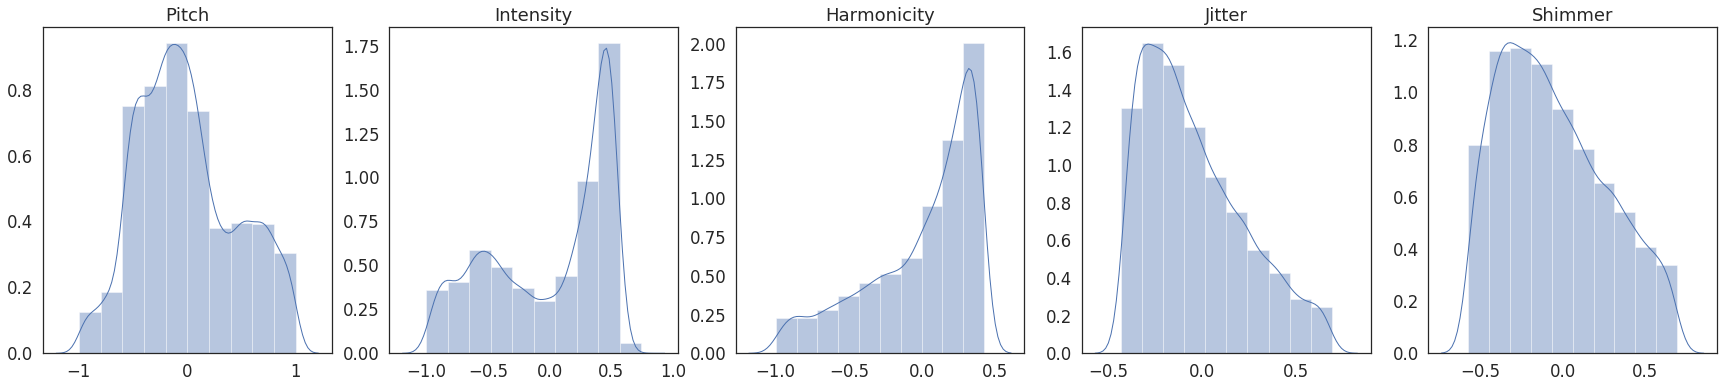

In [31]:
plt.figure(figsize=(30,6))

plt.subplot(1, 5, 1, title='Pitch')
sns.distplot(pitch_df_normalized['F0'].values, bins=10)

plt.subplot(1, 5, 2, title='Intensity')
sns.distplot(intensity_df_normalized['Intensity'].values, bins=10)

plt.subplot(1, 5, 3, title='Harmonicity')
sns.distplot(harmonicity_df_normalized['harmonicity'].values, bins=10)

plt.subplot(1, 5, 4, title='Jitter')
sns.distplot(jitter_df_normalized['jitter'].values, bins=10)

plt.subplot(1, 5, 5, title='Shimmer')
sns.distplot(shimmer_df_normalized['shimmer'].values, bins=10)

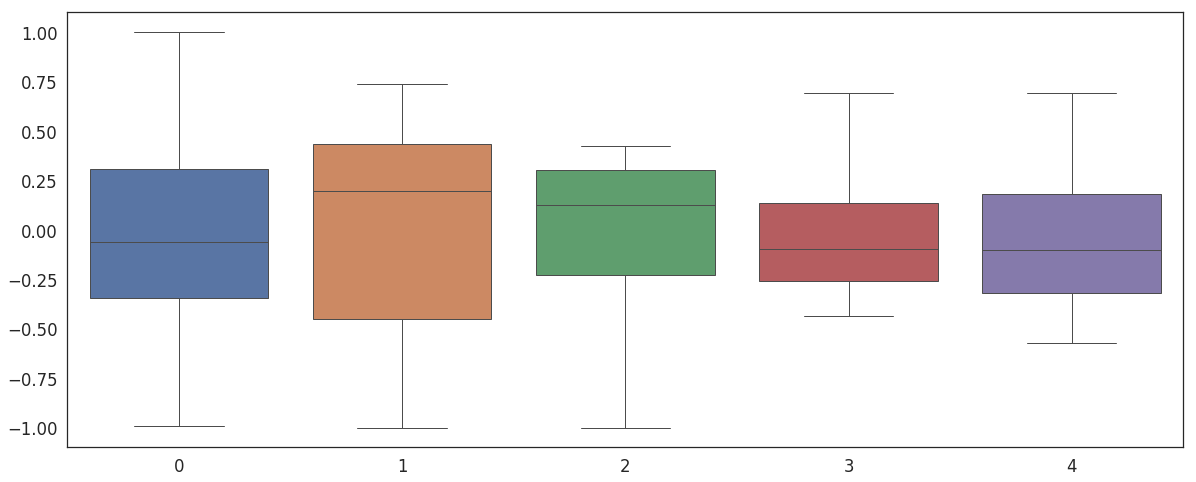

In [32]:
plt.figure(figsize=(20,8))

plt.plot()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})
ax = sns.boxplot(data=[pitch_df_normalized, intensity_df_normalized, harmonicity_df_normalized, jitter_df_normalized, shimmer_df_normalized])

In [33]:
# Extract silences from clean intensity tier
subprocess.call([PRAAT,
                 RUN_OPTIONS,
                 PRAAT_SCRIPT_SILENCES,
                 AUDIO_FILE,
                 CLEAN_INTENSITY_TIER,
                 SILENCES_TABLE,
                 str(SILENCE_THRESHOLD_DB),
                 str(MINIMUM_SILENT_INTERVAL_DURATION),
                 str(MINIMUM_SOUNDING_INTERVAL_DURATION),
                 str(dx_intensity),
                 str(TIME_DECIMALS)])

0

In [34]:
silences_df = pd.read_csv(SILENCES_TABLE, dtype=DTYPE_SILENCES)

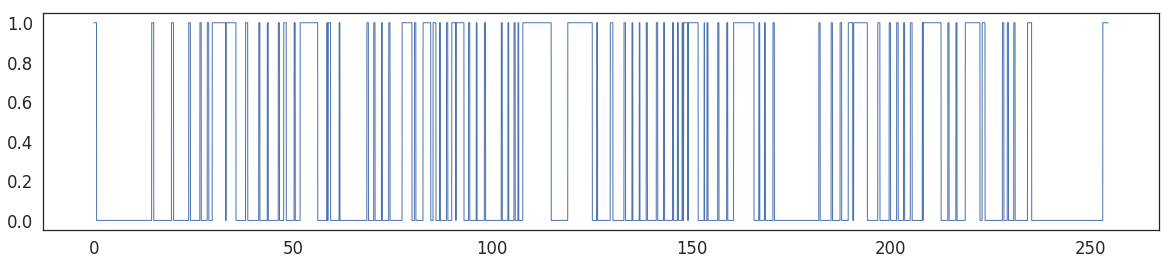

In [35]:
# Display silent intervals
time_sil = np.linspace(0, len(audio)/float(SAMPLE_RATE), len(audio))
silences = np.zeros(len(audio))
only_silent_df = silences_df[silences_df['text'] == 'silent']
for tmin, tmax in only_silent_df[['tmin', 'tmax']].values:
    silences[math.floor(tmin * SAMPLE_RATE):math.floor(tmax * SAMPLE_RATE)] = 1
plt.figure(figsize=(20,4))
plt.plot(time, silences)
voiced = np.abs(silences - 1)

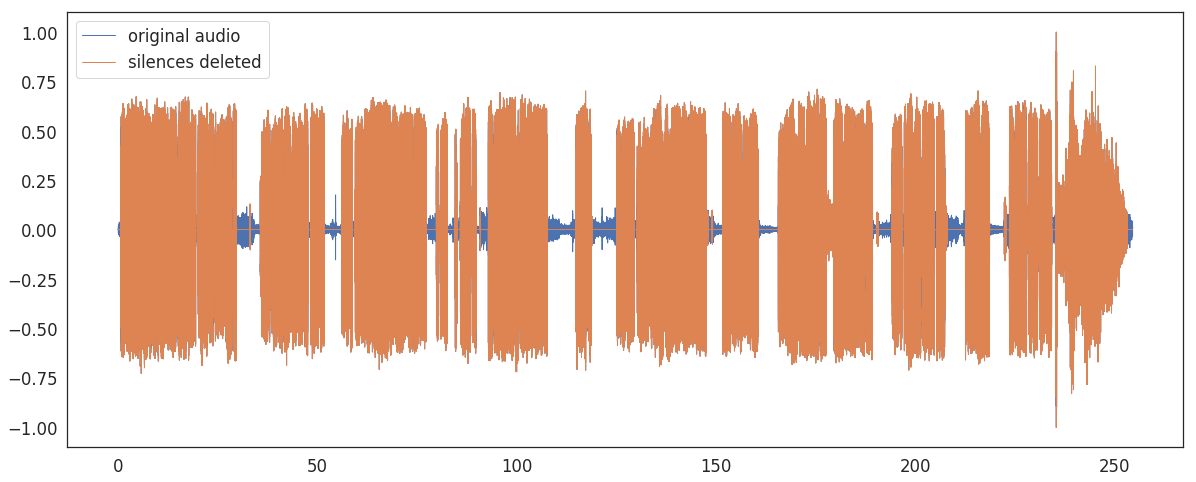

In [36]:
plt.figure(figsize=(20,8))
plt.plot(time, audio, label='original audio')
plt.plot(time_sil, audio * voiced, label='silences deleted')
plt.legend(loc='best')

In [37]:
silences_feature = np.zeros(math.floor(len(audio) / (HOP_SIZE * SAMPLE_RATE)))
only_silent_df = silences_df[silences_df['text'] == 'silent']
for tmin, tmax in only_silent_df[['tmin', 'tmax']].values:
    silences_feature[math.floor((tmin / HOP_SIZE)):math.floor((tmax / HOP_SIZE))] = 1
voiced_feature = np.abs(silences_feature - 1)

In [38]:
from scipy.interpolate import interp1d

# Select pitch from voiced intervals only
time_pitch_values = clean_pitch_tier_df[['Time', 'F0']].values
only_spoken_df = silences_df[silences_df['text'] == 'sounding']
spoken_intervals = only_spoken_df[['tmin', 'tmax']].values

ts, tmp = np.where((time_pitch_values[:, 0, None] >= spoken_intervals[:, 0]) & (time_pitch_values[:, 0, None] < spoken_intervals[:, 1]))
pitch = time_pitch_values[ts]

In [39]:
pitch[:, 1] = pitch[:, 1] - np.mean(pitch[:,1])
pitch[:, 1] = pitch[:, 1] / np.max(np.abs(pitch[:,1]))

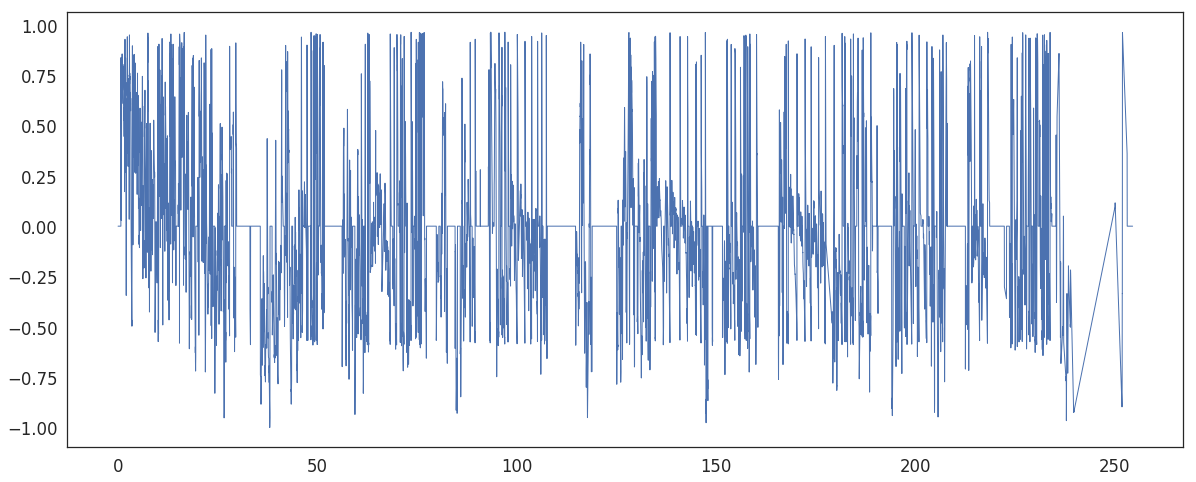

In [40]:
import scipy

interpol_pitch = interp1d(pitch[:, 0], pitch[:, 1], fill_value='extrapolate') #, kind='cubic')
new_pitch = interpol_pitch(time) * voiced

plt.figure(figsize=(20,8))
plt.plot(time, new_pitch)

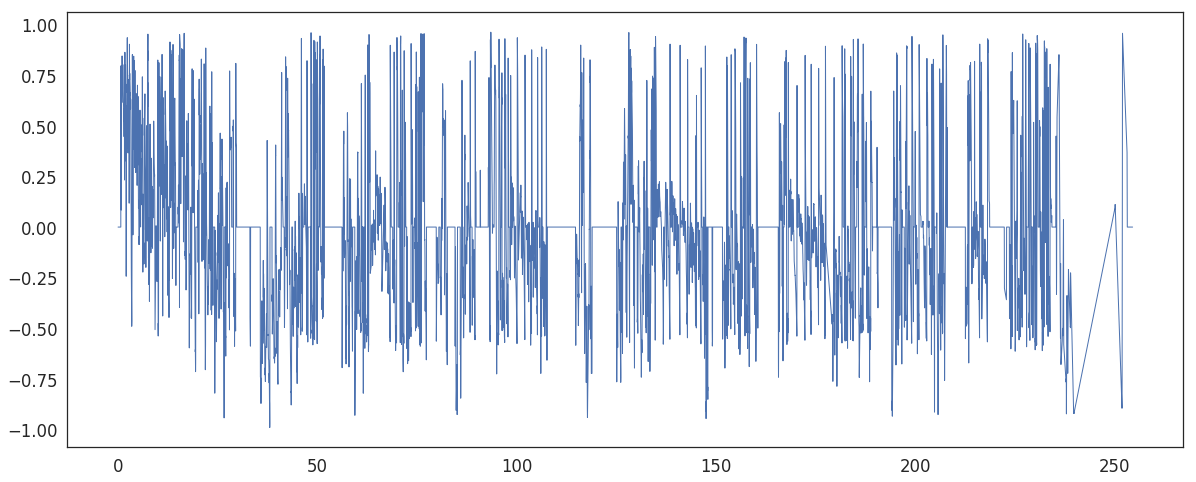

In [41]:
time_feature = np.linspace(0, len(audio)/float(SAMPLE_RATE), math.floor(len(audio) / (HOP_SIZE * SAMPLE_RATE)))
pitch_feature = list(map(lambda x: np.mean(x), [new_pitch[t*math.floor(HOP_SIZE * SAMPLE_RATE):min(len(audio), math.floor(((t * HOP_SIZE) + WINDOW_SIZE) * SAMPLE_RATE))] for t in range(time_feature.shape[0])]))
pitch_feature = np.array(pitch_feature) * voiced_feature

# pitch_feature = interpol_pitch(time_feature)

plt.figure(figsize=(20,8))
plt.plot(time_feature, pitch_feature)


In [42]:
# Select intensity from voiced intervals only
time_intensity_values = clean_intensity_tier_df[['Time', 'Intensity']].values
only_spoken_df = silences_df[silences_df['text'] == 'sounding']
spoken_intervals = only_spoken_df[['tmin', 'tmax']].values

ts, tmp = np.where((time_intensity_values[:, 0, None] >= spoken_intervals[:, 0]) & (time_intensity_values[:, 0, None] < spoken_intervals[:, 1]))
intensity = time_intensity_values[ts]

In [43]:
intensity[:, 1] = intensity[:, 1] - np.mean(intensity[:,1])
intensity[:, 1] = intensity[:, 1] / np.max(np.abs(intensity[:,1]))

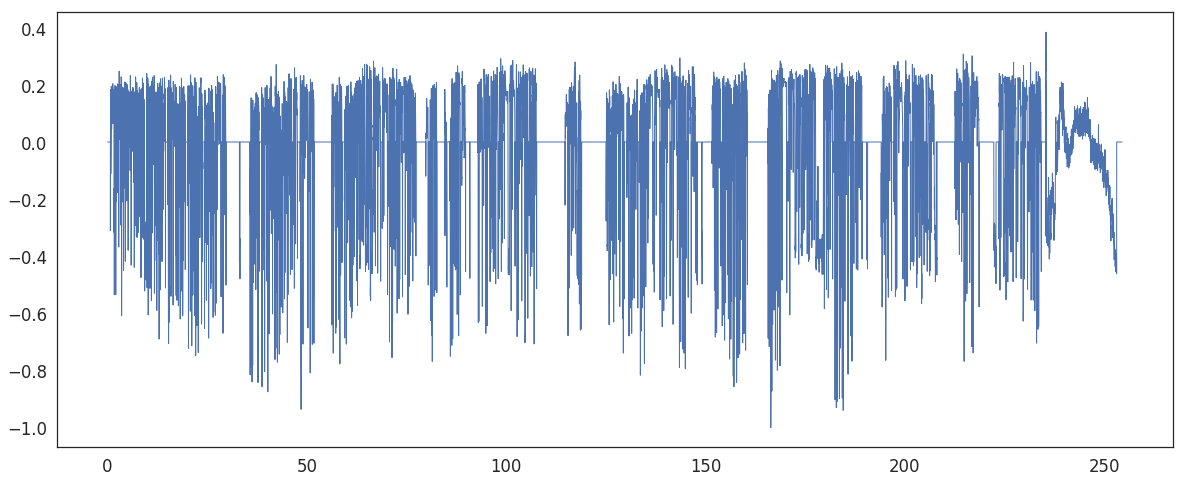

In [44]:
interpol_intensity = interp1d(intensity[:, 0], intensity[:, 1], fill_value='extrapolate') #, kind='cubic')
new_intensity = interpol_intensity(time) * voiced

plt.figure(figsize=(20,8))
plt.plot(time, new_intensity)

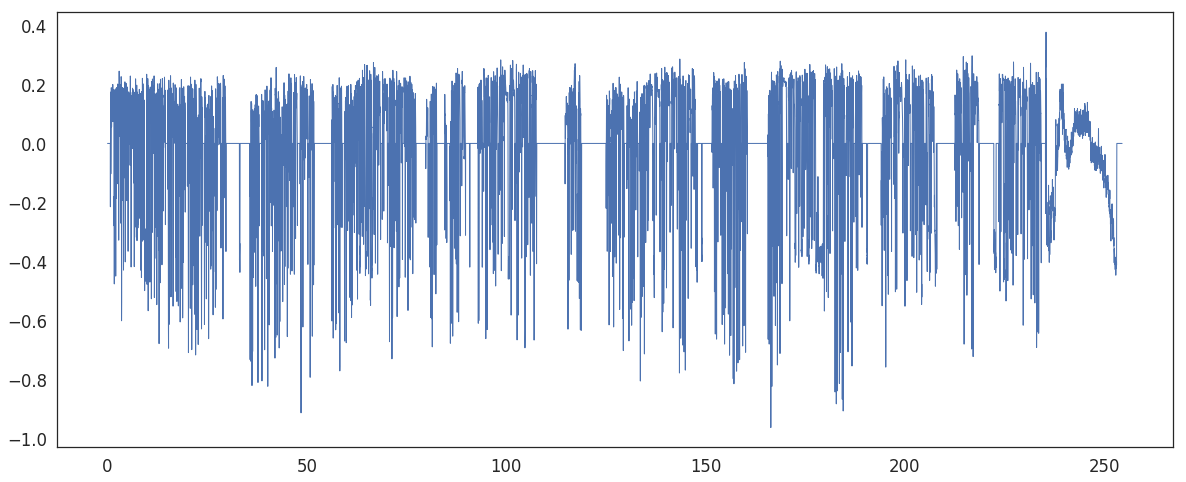

In [45]:
intensity_feature = list(map(lambda x: np.mean(x), [new_intensity[t*math.floor(HOP_SIZE * SAMPLE_RATE):min(len(audio), math.floor(((t * HOP_SIZE) + WINDOW_SIZE) * SAMPLE_RATE))] for t in range(time_feature.shape[0])]))
intensity_feature = np.array(intensity_feature) * voiced_feature

# pitch_feature = interpol_pitch(time_feature)

plt.figure(figsize=(20,8))
plt.plot(time_feature, intensity_feature)

In [46]:
# Extract only harmonicity data frame
clean_harmonicity_df = clean_voice_report_df[['start_time', 'end_time', 'harmonicity']].dropna(axis=0)

clean_harmonicity_new_values = np.array([((x[0] + x[1]) / 2, x[2]) for x in clean_harmonicity_df[['start_time', 'end_time', 'harmonicity']].values])
clean_harmonicity_df = pd.DataFrame(data=clean_harmonicity_new_values, columns=['Time', 'Harmonicity'])

# Clean harmonicity from outliers
mean = np.mean(clean_harmonicity_new_values[:, 1], axis=0)
std = np.std(clean_harmonicity_new_values[:, 1], axis=0)
query = "Harmonicity >= " + str(mean) + " - " + str(N_SIGMA * std) + " and Harmonicity <= " + str(mean) + " + " + str(N_SIGMA * std)
clean_harmonicity_df = clean_harmonicity_df.query(query)

In [47]:
# Select harmonicity from voiced intervals only
time_harmonicity_values = clean_harmonicity_df[['Time', 'Harmonicity']].values
only_spoken_df = silences_df[silences_df['text'] == 'sounding']
spoken_intervals = only_spoken_df[['tmin', 'tmax']].values

ts, tmp = np.where((time_harmonicity_values[:, 0, None] >= spoken_intervals[:, 0]) & (time_harmonicity_values[:, 0, None] < spoken_intervals[:, 1]))
harmonicity = time_harmonicity_values[ts]

In [48]:
harmonicity[:, 1] = harmonicity[:, 1] - np.mean(harmonicity[:,1])
harmonicity[:, 1] = harmonicity[:, 1] / np.max(np.abs(harmonicity[:,1]))

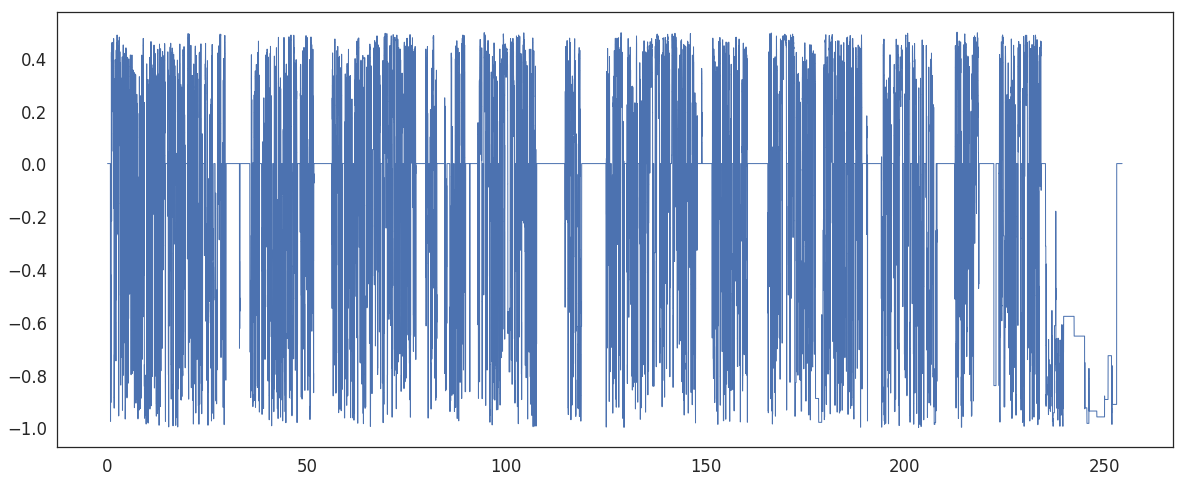

In [49]:
interpol_harmonicity = interp1d(harmonicity[:, 0], harmonicity[:, 1], fill_value='extrapolate', kind='nearest')
new_harmonicity = interpol_harmonicity(time) * voiced

plt.figure(figsize=(20,8))
plt.plot(time, new_harmonicity)

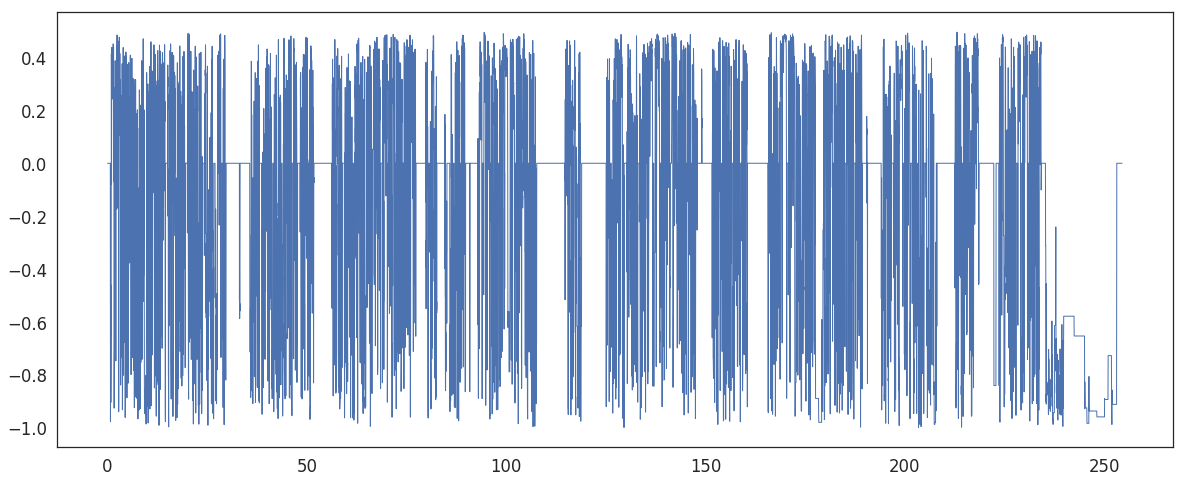

In [50]:
harmonicity_feature = list(map(lambda x: np.mean(x), [new_harmonicity[t*math.floor(HOP_SIZE * SAMPLE_RATE):min(len(audio), math.floor(((t * HOP_SIZE) + WINDOW_SIZE) * SAMPLE_RATE))] for t in range(time_feature.shape[0])]))
harmonicity_feature = np.array(harmonicity_feature) * voiced_feature

# pitch_feature = interpol_pitch(time_feature)

plt.figure(figsize=(20,8))
plt.plot(time_feature, harmonicity_feature)

In [51]:
# Extract only harmonicity data frame
clean_jitter_df = clean_voice_report_df[['start_time', 'end_time', 'jitter']].dropna(axis=0)

clean_jitter_new_values = np.array([((x[0] + x[1]) / 2, x[2]) for x in clean_jitter_df[['start_time', 'end_time', 'jitter']].values])
clean_jitter_df = pd.DataFrame(data=clean_jitter_new_values, columns=['Time', 'Jitter'])

# Clean harmonicity from outliers
mean = np.mean(clean_jitter_new_values[:, 1], axis=0)
std = np.std(clean_jitter_new_values[:, 1], axis=0)
query = "Jitter >= " + str(mean) + " - " + str(N_SIGMA * std) + " and Jitter <= " + str(mean) + " + " + str(N_SIGMA * std)
clean_jitter_df = clean_jitter_df.query(query)

In [52]:
# Select harmonicity from voiced intervals only
time_jitter_values = clean_jitter_df[['Time', 'Jitter']].values
only_spoken_df = silences_df[silences_df['text'] == 'sounding']
spoken_intervals = only_spoken_df[['tmin', 'tmax']].values

ts, tmp = np.where((time_jitter_values[:, 0, None] >= spoken_intervals[:, 0]) & (time_jitter_values[:, 0, None] < spoken_intervals[:, 1]))
jitter = time_jitter_values[ts]

In [53]:
#jitter[:, 1] = np.log1p(jitter[:, 1])
jitter[:, 1] = jitter[:, 1] - np.mean(jitter[:,1])
jitter[:, 1] = jitter[:, 1] / np.max(np.abs(jitter[:,1]))

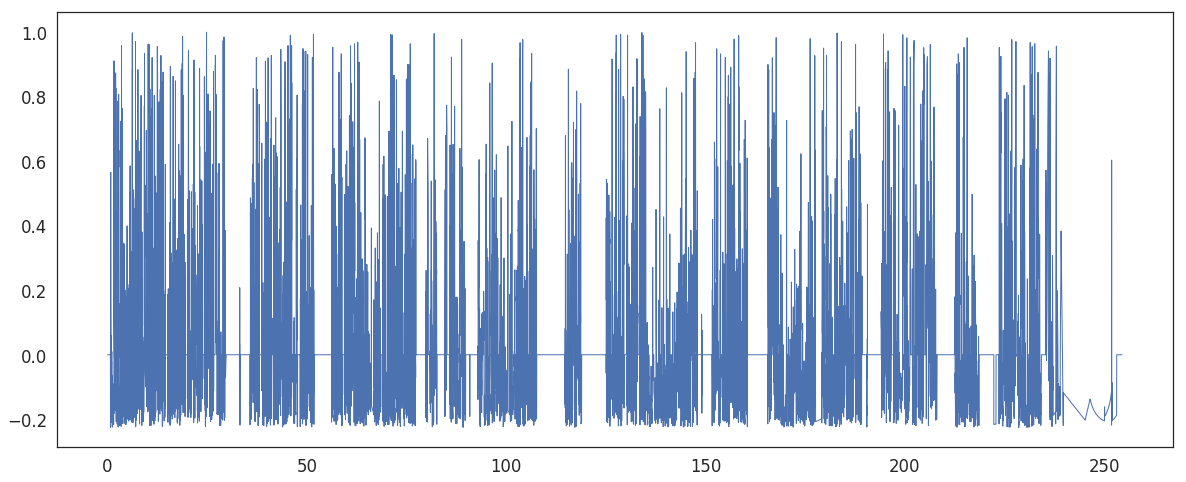

In [54]:
interpol_jitter = interp1d(jitter[:, 0], jitter[:, 1], fill_value='extrapolate') #, kind='cubic')
new_jitter = interpol_jitter(time) * voiced

plt.figure(figsize=(20,8))
plt.plot(time, new_jitter)

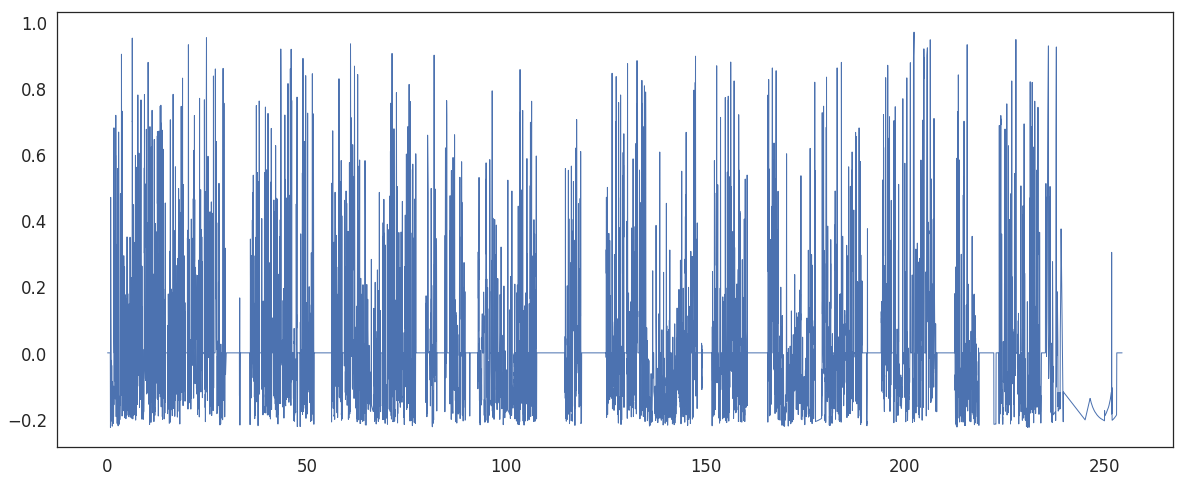

In [55]:
jitter_feature = list(map(lambda x: np.mean(x), [new_jitter[t*math.floor(HOP_SIZE * SAMPLE_RATE):min(len(audio), math.floor(((t * HOP_SIZE) + WINDOW_SIZE) * SAMPLE_RATE))] for t in range(time_feature.shape[0])]))
jitter_feature = np.array(jitter_feature) * voiced_feature

# pitch_feature = interpol_pitch(time_feature)

plt.figure(figsize=(20,8))
plt.plot(time_feature, jitter_feature)

In [56]:
# Extract only harmonicity data frame
clean_shimmer_df = clean_voice_report_df[['start_time', 'end_time', 'shimmer']].dropna(axis=0)

clean_shimmer_new_values = np.array([((x[0] + x[1]) / 2, x[2]) for x in clean_shimmer_df[['start_time', 'end_time', 'shimmer']].values])
clean_shimmer_df = pd.DataFrame(data=clean_shimmer_new_values, columns=['Time', 'Shimmer'])

# Clean harmonicity from outliers
mean = np.mean(clean_shimmer_new_values[:, 1], axis=0)
std = np.std(clean_shimmer_new_values[:, 1], axis=0)
query = "Shimmer >= " + str(mean) + " - " + str(N_SIGMA * std) + " and Shimmer <= " + str(mean) + " + " + str(N_SIGMA * std)
clean_shimmer_df = clean_shimmer_df.query(query)

In [57]:
# Select harmonicity from voiced intervals only
time_shimmer_values = clean_shimmer_df[['Time', 'Shimmer']].values
only_spoken_df = silences_df[silences_df['text'] == 'sounding']
spoken_intervals = only_spoken_df[['tmin', 'tmax']].values

ts, tmp = np.where((time_shimmer_values[:, 0, None] >= spoken_intervals[:, 0]) & (time_shimmer_values[:, 0, None] < spoken_intervals[:, 1]))
shimmer = time_shimmer_values[ts]

In [58]:
# vedere dove mettere jitter_df_normalized_values = np.log1p(jitter_df_normalized_values)
shimmer[:, 1] = shimmer[:, 1] - np.mean(shimmer[:,1])
shimmer[:, 1] = shimmer[:, 1] / np.max(np.abs(shimmer[:,1]))

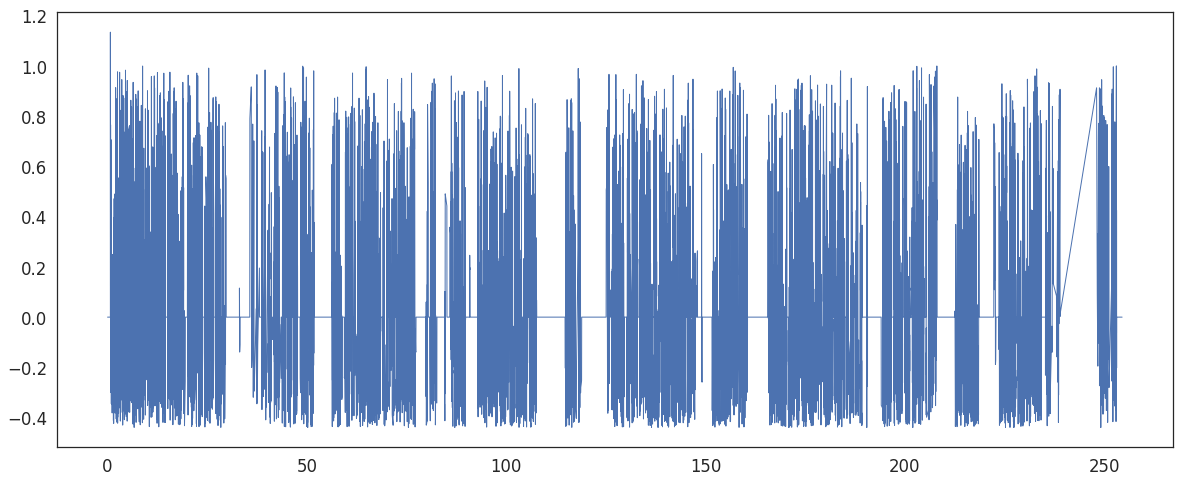

In [59]:
interpol_shimmer = interp1d(shimmer[:, 0], shimmer[:, 1], fill_value='extrapolate') #, kind='cubic')
new_shimmer = interpol_shimmer(time) * voiced

plt.figure(figsize=(20,8))
plt.plot(time, new_shimmer)

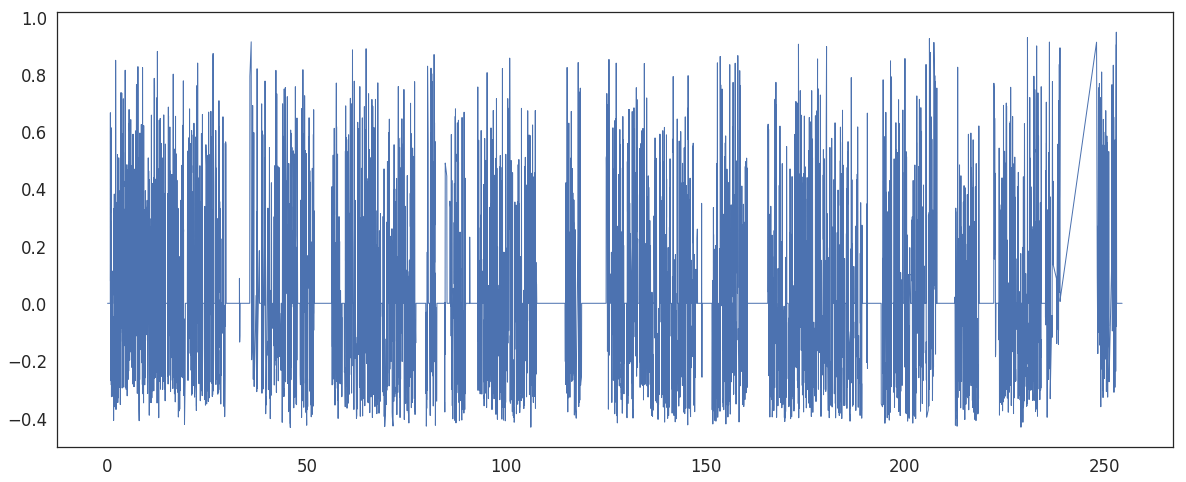

In [60]:
shimmer_feature = list(map(lambda x: np.mean(x), [new_shimmer[t*math.floor(HOP_SIZE * SAMPLE_RATE):min(len(audio), math.floor(((t * HOP_SIZE) + WINDOW_SIZE) * SAMPLE_RATE))] for t in range(time_feature.shape[0])]))
shimmer_feature = np.array(shimmer_feature) * voiced_feature

# pitch_feature = interpol_pitch(time_feature)

plt.figure(figsize=(20,8))
plt.plot(time_feature, shimmer_feature)

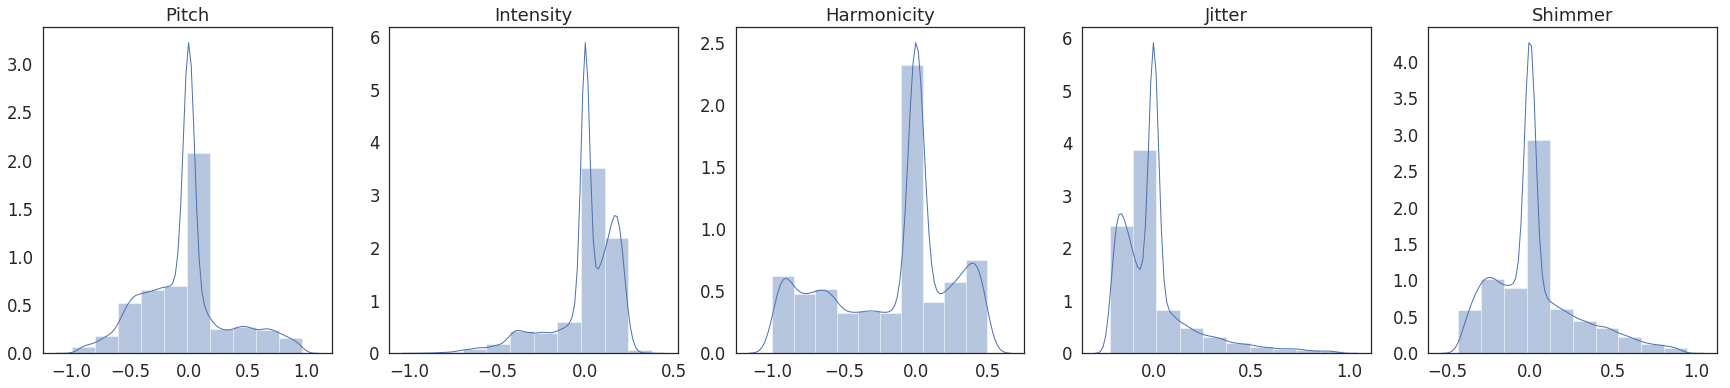

In [61]:
plt.figure(figsize=(30,6))

plt.subplot(1, 5, 1, title='Pitch')
sns.distplot(pitch_feature, bins=10)

plt.subplot(1, 5, 2, title='Intensity')
sns.distplot(intensity_feature, bins=10)

plt.subplot(1, 5, 3, title='Harmonicity')
sns.distplot(harmonicity_feature, bins=10)

plt.subplot(1, 5, 4, title='Jitter')
sns.distplot(jitter_feature, bins=10)

plt.subplot(1, 5, 5, title='Shimmer')
sns.distplot(shimmer_feature, bins=10)

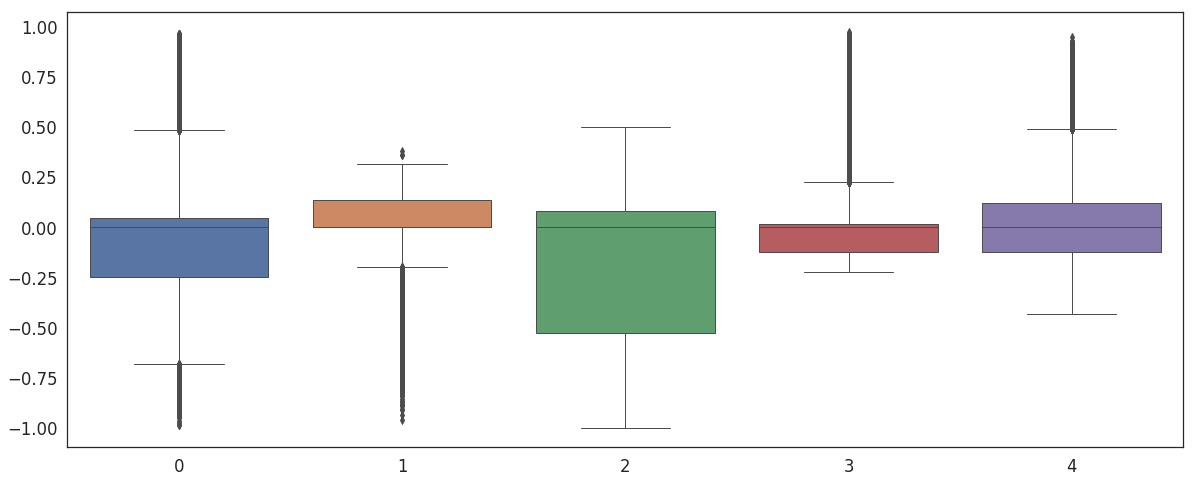

In [62]:
plt.figure(figsize=(20,8))

plt.plot()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})
ax = sns.boxplot(data=[pitch_feature, intensity_feature, harmonicity_feature, jitter_feature, shimmer_feature])

In [63]:
praat_data = np.array([time_feature, silences_feature, pitch_feature, intensity_feature, harmonicity_feature, jitter_feature, shimmer_feature]).T
praat_data_df = pd.DataFrame(data=praat_data, columns=['Time', 'Silences', 'Pitch', 'Intensity', 'Harmonicity', 'Jitter', 'Shimmer'])

PRAAT_DF_FN = AUDIO_FILE[:-EXT_SIZE] + '_praat_features.csv'

praat_data_df.to_csv(PRAAT_DF_FN, index=False)

In [64]:
sample_rate, audio = wavfile.read(AUDIO_FILE)
audio_feature = audio * voiced

AUDIO_CLEANED = AUDIO_FILE[:-EXT_SIZE] + '_cleaned.wav'

wavfile.write(AUDIO_CLEANED, sample_rate, audio_feature)

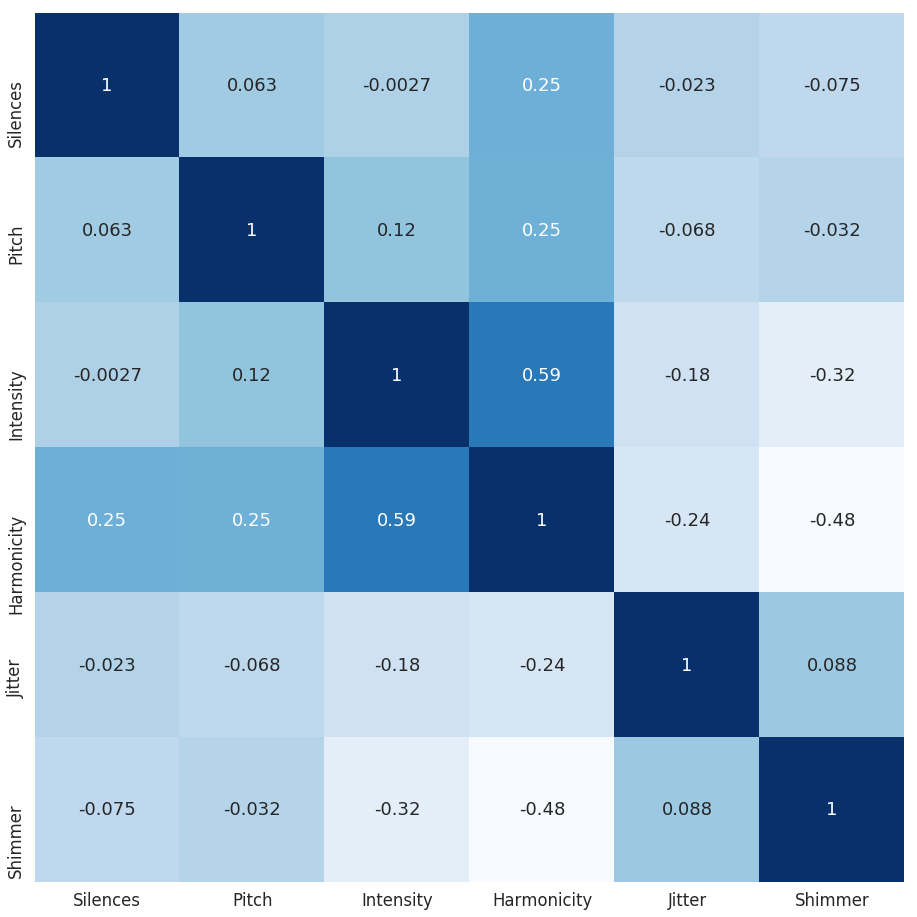

In [65]:
cov=praat_data_df[['Silences', 'Pitch', 'Intensity', 'Harmonicity', 'Jitter', 'Shimmer']].corr(method='pearson')
plt.figure(figsize = (16,16))
sns.heatmap(cov,square=True,annot=True,cmap="Blues",cbar=False,xticklabels=True, yticklabels=True)

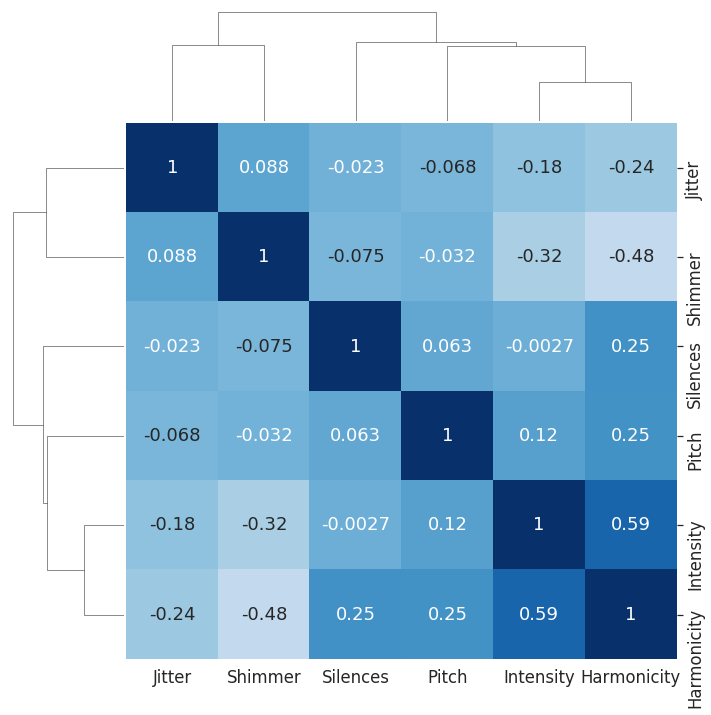

In [66]:
cm = sns.clustermap(cov, annot=True, center=0, cmap="Blues", figsize=(12, 12))
cm.cax.set_visible(False)